In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
RANDOM_STATE = 1
df = pd.read_csv("../data/clean_train.csv")
df.head(3)


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,child,cabin_deck,solo
0,0,lower,"braund,_mr._owen_harris",male,22.0,1,0,a/5_21171,7.2500,unknown,s,0,u,solo
1,1,upper,"cumings,_mrs._john_bradley_(florence_briggs_th...",female,38.0,1,0,pc_17599,71.2833,c85,c,0,c,solo
2,1,lower,"heikkinen,_miss._laina",female,26.0,0,0,ston/o2._3101282,7.9250,unknown,s,0,u,not_solo


In [89]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

y_train = df_train['survived'].values
y_val = df_val['survived'].values

del df_train['survived']
del df_val['survived']

In [90]:
numerical_features = ['age', 'sibsp', 'parch', 'fare']
categorical_features = ['pclass', 'sex', 'embarked', 'cabin_deck', 'solo']


In [91]:
def train(df_train, y_train, features, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, features, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred



In [92]:
dv, model = train(df_train, y_train, categorical_features + numerical_features)
y_pred = predict(df_val, dv, categorical_features + numerical_features, model)
y_pred_train = predict(df_train, dv, categorical_features + numerical_features, model)


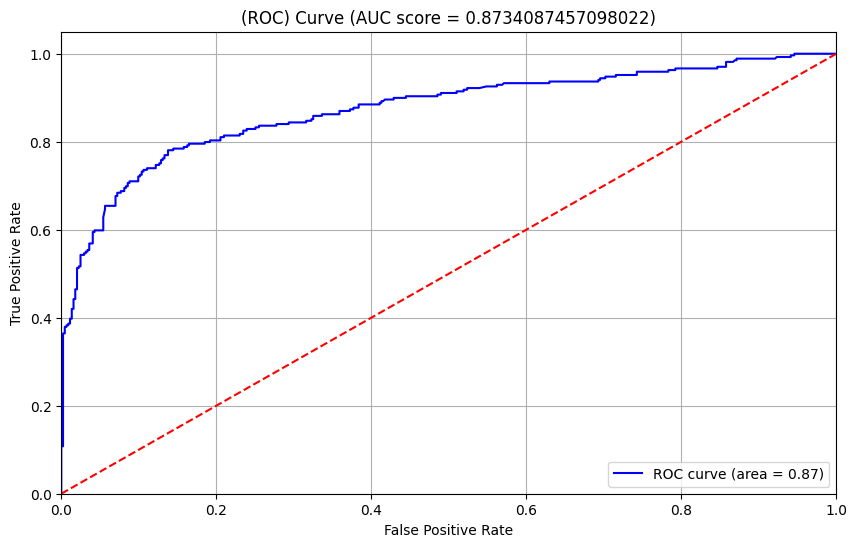

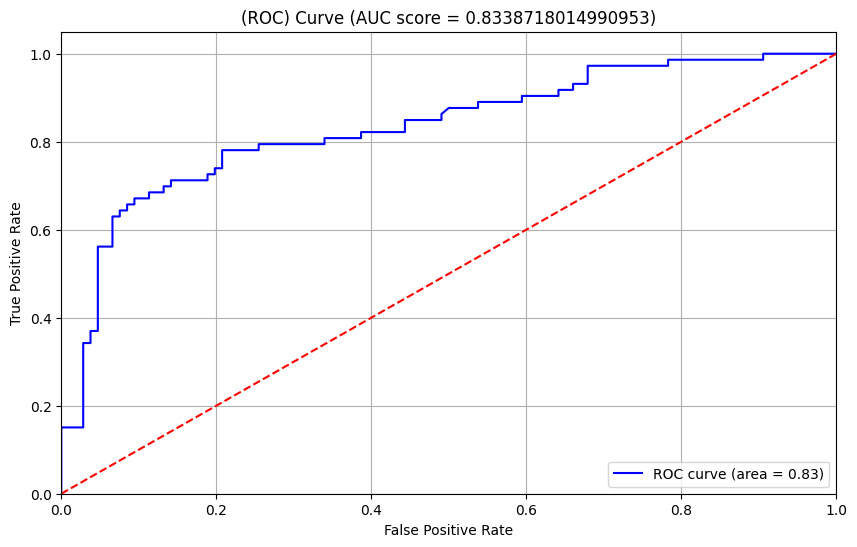

In [93]:
# plot roc curve
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true=y_true, y_score=y_score)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'(ROC) Curve (AUC score = {auc_score})')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
plot_roc_curve(y_true=y_train, y_score=y_pred_train)
plot_roc_curve(y_true=y_val, y_score=y_pred)

In [94]:
coeff_scores = list(zip(abs(model.coef_[0].round(3)), dv.get_feature_names_out()))
coeff_scores.sort(reverse=True)
coeff_scores

[(np.float64(1.286), 'sex=female'),
 (np.float64(1.27), 'sex=male'),
 (np.float64(1.126), 'cabin_deck=e'),
 (np.float64(0.924), 'pclass=lower'),
 (np.float64(0.886), 'cabin_deck=u'),
 (np.float64(0.578), 'pclass=upper'),
 (np.float64(0.547), 'sibsp'),
 (np.float64(0.4), 'embarked=s'),
 (np.float64(0.4), 'cabin_deck=c'),
 (np.float64(0.369), 'solo=solo'),
 (np.float64(0.362), 'pclass=middle'),
 (np.float64(0.354), 'solo=not_solo'),
 (np.float64(0.332), 'cabin_deck=d'),
 (np.float64(0.326), 'cabin_deck=f'),
 (np.float64(0.273), 'cabin_deck=t'),
 (np.float64(0.261), 'cabin_deck=b'),
 (np.float64(0.256), 'cabin_deck=g'),
 (np.float64(0.214), 'cabin_deck=a'),
 (np.float64(0.185), 'embarked=unknown'),
 (np.float64(0.183), 'embarked=q'),
 (np.float64(0.136), 'parch'),
 (np.float64(0.048), 'embarked=c'),
 (np.float64(0.04), 'age'),
 (np.float64(0.001), 'fare')]

In [95]:
features = ['sex', 'cabin_deck', 'pclass', 'parch']
dv, model = train(df_train, y_train, features)
y_pred = predict(df_val, dv, features, model)
y_pred_train = predict(df_train, dv, features, model)

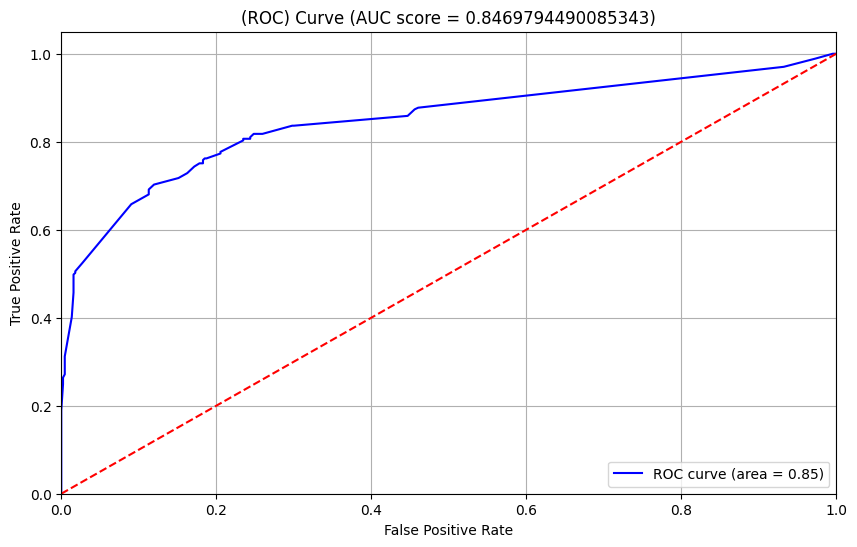

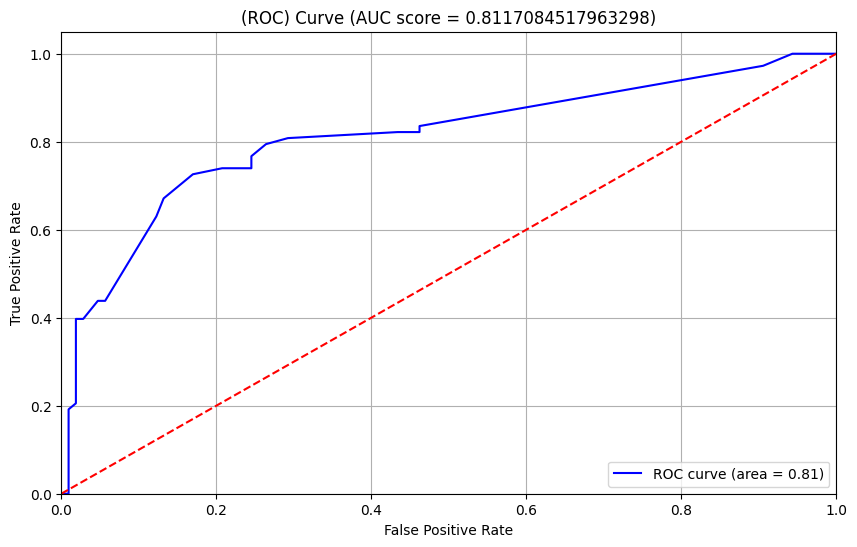

In [96]:
plot_roc_curve(y_true=y_train, y_score=y_pred_train)
plot_roc_curve(y_true=y_val, y_score=y_pred)